In [14]:
# Cell 1: Setup (RUN THIS CELL FIRST)
# - Creates folder structure
# - Checks and prints library versions
# - Downloads Haar Cascade for face detection if missing
# - Initializes attendance.csv with headers if missing
# - Defines global constants used later

import os
import sys
from pathlib import Path
from datetime import datetime
import urllib.request

import cv2
import numpy as np
import pandas as pd
import matplotlib
import sklearn

# Print environment info
print("Environment info:")
print(f"Python: {sys.version.split()[0]}")
print(f"OpenCV: {cv2.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"scikit-learn: {sklearn.__version__}")

# Define base paths
BASE_DIR = Path.cwd()
PROJECT_DIR = BASE_DIR  # notebook stored under attendance_system/
DATASET_DIR = PROJECT_DIR / "dataset"
MODELS_DIR = PROJECT_DIR / "models"
ATTENDANCE_CSV = PROJECT_DIR / "attendance.csv"
HAAR_PATH = MODELS_DIR / "haarcascade_frontalface_default.xml"

# Constants
IMG_SIZE = 64  # resize to 64x64
PCA_COMPONENTS = 100
MAX_PEOPLE = 10

print("\nSetting up folders...")
for p in [PROJECT_DIR, DATASET_DIR, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)
print(f"Project dir: {PROJECT_DIR}")
print(f"Dataset dir: {DATASET_DIR}")
print(f"Models dir: {MODELS_DIR}")

# Optionally pre-create person subfolders (person1..person10)
for i in range(1, MAX_PEOPLE + 1):
    person_dir = DATASET_DIR / f"person{i}"
    person_dir.mkdir(exist_ok=True)

# Download Haar Cascade if not present
if not HAAR_PATH.exists():
    print("Haar cascade not found. Downloading...")
    try:
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
        urllib.request.urlretrieve(url, str(HAAR_PATH))
        print(f"Downloaded Haar cascade to: {HAAR_PATH}")
    except Exception as e:
        print("ERROR: Failed to download Haar cascade. Please ensure internet access or add the file manually.")
        print(f"Details: {e}")
else:
    print(f"Haar cascade present: {HAAR_PATH}")

# Initialize attendance.csv if missing
if not ATTENDANCE_CSV.exists():
    print("Creating attendance.csv with headers [name,date,time]...")
    try:
        df = pd.DataFrame(columns=["name", "date", "time"])  # empty with headers
        df.to_csv(ATTENDANCE_CSV, index=False)
        print(f"Created: {ATTENDANCE_CSV}")
    except Exception as e:
        print("ERROR: Could not create attendance.csv")
        print(f"Details: {e}")
else:
    print(f"Found existing attendance.csv: {ATTENDANCE_CSV}")

print("\nSetup complete. Proceed to the next cell after confirming this ran without errors.")


Environment info:
Python: 3.13.5
OpenCV: 4.12.0
NumPy: 2.1.3
Pandas: 2.2.3
Matplotlib: 3.10.0
scikit-learn: 1.6.1

Setting up folders...
Project dir: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main
Dataset dir: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\dataset
Models dir: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\models
Haar cascade present: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\models\haarcascade_frontalface_default.xml
Found existing attendance.csv: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\attendance.csv

Setup complete. Proceed to the next cell after confirming this ran without errors.


In [15]:
# Cell 2: Utilities - Detection, Preprocessing, Dataset Helpers (RUN THIS CELL FIRST IN NEW SESSIONS)
# - Face detection using Haar Cascade
# - Preprocessing: grayscale, histogram equalization, resize to 64x64
# - Dataset scanning and loading with labels
# - Safe image reading and error handling

import os
from pathlib import Path
from typing import List, Tuple, Dict

import cv2
import numpy as np
import pandas as pd

# Reuse globals from Cell 1: HAAR_PATH, DATASET_DIR, IMG_SIZE

# Load Haar Cascade
_face_cascade = None

def get_face_cascade():
    global _face_cascade
    if _face_cascade is None:
        if not Path(HAAR_PATH).exists():
            raise FileNotFoundError(f"Haar cascade not found at {HAAR_PATH}. Run Cell 1 or place the file.")
        _face_cascade = cv2.CascadeClassifier(str(HAAR_PATH))
        if _face_cascade.empty():
            raise RuntimeError("Failed to load Haar cascade. The file may be corrupt.")
    return _face_cascade


def detect_faces_gray(image_bgr: np.ndarray, scaleFactor: float = 1.3, minNeighbors: int = 5) -> List[Tuple[int, int, int, int]]:
    """Detect faces on a BGR image and return list of (x, y, w, h)."""
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    faces = get_face_cascade().detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)
    return [(int(x), int(y), int(w), int(h)) for (x, y, w, h) in faces]


def preprocess_face_crop(image_bgr: np.ndarray, bbox: Tuple[int, int, int, int]) -> np.ndarray:
    """Given a BGR image and a face bbox (x,y,w,h), return processed 64x64 grayscale face."""
    x, y, w, h = bbox
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    face = gray[y:y+h, x:x+w]
    if face.size == 0:
        raise ValueError("Empty face crop. Check bbox.")
    # Histogram equalization and resize
    face = cv2.equalizeHist(face)
    face = cv2.resize(face, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    return face


def preprocess_image_path(image_path: Path) -> List[np.ndarray]:
    """Read an image path safely, detect faces, and return list of processed faces (64x64)."""
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"WARN: Could not read image: {image_path}")
        return []
    bboxes = detect_faces_gray(img)
    if len(bboxes) == 0:
        # As a fallback, try entire image if no faces detected (for synthetic samples)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        return [resized]
    faces = []
    for bbox in bboxes:
        try:
            faces.append(preprocess_face_crop(img, bbox))
        except Exception as e:
            print(f"WARN: Failed to preprocess face in {image_path}: {e}")
    return faces


def list_people(dataset_dir: Path) -> List[str]:
    people = []
    for entry in sorted(dataset_dir.iterdir()):
        if entry.is_dir():
            people.append(entry.name)
    return people


def load_dataset(dataset_dir: Path) -> Tuple[np.ndarray, np.ndarray, Dict[int, str]]:
    """Scan dataset folders, preprocess faces, and build X, y and id->name mapping.
    - X: (N, IMG_SIZE*IMG_SIZE) grayscale flattened
    - y: (N,) integer labels
    - id_to_name: dict mapping label id to folder name
    """
    people = list_people(dataset_dir)
    if len(people) == 0:
        print(f"NOTE: No person folders found in {dataset_dir}. You can run the sample data cell next.")
    id_to_name = {i: name for i, name in enumerate(people)}
    name_to_id = {name: i for i, name in id_to_name.items()}

    X_list, y_list = [], []
    for name in people:
        person_dir = dataset_dir / name
        image_files = [p for p in person_dir.iterdir() if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}]
        if len(image_files) == 0:
            print(f"WARN: No images in {person_dir}")
        for img_path in image_files:
            faces = preprocess_image_path(img_path)
            for face in faces:
                X_list.append(face.flatten().astype(np.float32) / 255.0)
                y_list.append(name_to_id[name])

    if len(X_list) == 0:
        print("WARN: Dataset appears empty after preprocessing.")
        return np.empty((0, IMG_SIZE * IMG_SIZE), dtype=np.float32), np.empty((0,), dtype=np.int64), id_to_name

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    print(f"Loaded dataset: X={X.shape}, y={y.shape}, classes={len(id_to_name)}")
    return X, y, id_to_name

print("Utilities loaded. You can proceed.")


Utilities loaded. You can proceed.


In [16]:
# Cell 3: Sample Data Creation (optional, for testing) - Creates simple synthetic faces
# - Generates 10 folders person1..person10 if not present
# - Creates 5 synthetic 64x64 grayscale images per person
# - These are simplistic and only for pipeline testing; replace with real images later

import numpy as np
import cv2
from pathlib import Path

NUM_PEOPLE = 10
IMAGES_PER_PERSON = 5

created = 0
for i in range(1, NUM_PEOPLE + 1):
    person_dir = DATASET_DIR / f"person{i}"
    person_dir.mkdir(exist_ok=True)
    existing = list(person_dir.glob("*.png")) + list(person_dir.glob("*.jpg"))
    to_create = max(0, IMAGES_PER_PERSON - len(existing))
    for j in range(to_create):
        # Simple synthetic pattern with noise, circle/ellipse variations
        img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
        cv2.circle(img, (IMG_SIZE//2, IMG_SIZE//2), 20 + (i % 5), 150 + (i*8) % 100, -1)
        cv2.ellipse(img, (IMG_SIZE//2, IMG_SIZE//2 + 10), (10 + (j%3)*3, 5 + (j%3)*2), 0, 0, 360, 80 + (j*20), -1)
        noise = (np.random.randn(IMG_SIZE, IMG_SIZE) * 8).astype(np.int16)
        noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        out = cv2.equalizeHist(noisy)
        out_path = person_dir / f"synthetic_{j+1}.png"
        cv2.imwrite(str(out_path), out)
        created += 1

print(f"Synthetic images created: {created}")
print("If you have real face images, place 5-10 images per person folder.")


Synthetic images created: 0
If you have real face images, place 5-10 images per person folder.


In [17]:
# Cell 4: Load dataset and train/test split
# - Loads images from dataset/, preprocesses faces
# - Builds X (flattened 64x64) and y (labels)
# - Train/test split with stratification

from sklearn.model_selection import train_test_split

# Load
X, y, id_to_name = load_dataset(DATASET_DIR)
name_to_id = {v: k for k, v in id_to_name.items()}
print("Label map:", id_to_name)

if X.shape[0] == 0 or len(id_to_name) == 0:
    raise RuntimeError("Dataset is empty. Add images or run Cell 3 to generate samples.")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Loaded dataset: X=(65, 4096), y=(65,), classes=11
Label map: {0: 'person1', 1: 'person10', 2: 'person2', 3: 'person3', 4: 'person4', 5: 'person5', 6: 'person6', 7: 'person7', 8: 'person8', 9: 'person9', 10: 'preeti'}
Train: (45, 4096), Test: (20, 4096)


In [18]:
# Cell 5: PCA (100 components) fit on training set and transform train/test
# - Caps components by min(n_samples, n_features)
# - Uses efficient solver selection

from sklearn.decomposition import PCA
import joblib

max_components = min(PCA_COMPONENTS, X_train.shape[1], X_train.shape[0])
if max_components <= 0:
    raise RuntimeError("PCA cannot run: not enough training samples or features.")

# Use randomized when components are less than min(n_samples, n_features) for speed
svd_solver = 'randomized' if max_components < min(X_train.shape[0], X_train.shape[1]) else 'full'

pca = PCA(n_components=max_components, svd_solver=svd_solver, whiten=False, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA fitted. Components: {pca.n_components_}, solver: {svd_solver}")
print(f"Shapes -> train: {X_train_pca.shape}, test: {X_test_pca.shape}")


PCA fitted. Components: 45, solver: full
Shapes -> train: (45, 45), test: (20, 45)


In [19]:
# Cell 6: Train and compare classifiers (SVM, Logistic Regression, Decision Tree, Random Forest)
# - Trains each on PCA features
# - Reports accuracy and confidence proxy (decision_function/proba max)
# - Selects best model

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

models = {
    "SVM_RBF": SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42),
    "LogReg": LogisticRegression(max_iter=2000, multi_class='auto', solver='lbfgs'),
    "DecisionTree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, clf in models.items():
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "model": clf,
        "accuracy": acc
    }
    print(f"{name} accuracy: {acc:.3f}")

# Pick best by accuracy
best_name = max(results, key=lambda k: results[k]["accuracy"])
best_model = results[best_name]["model"]
print(f"\nBest model: {best_name} (accuracy={results[best_name]['accuracy']:.3f})")

# Example: show per-class report for the best model
print("\nClassification report for best model:")
best_pred = best_model.predict(X_test_pca)
print(classification_report(y_test, best_pred, target_names=[id_to_name[i] for i in sorted(id_to_name.keys())]))


SVM_RBF accuracy: 0.350
LogReg accuracy: 0.350
DecisionTree accuracy: 0.550


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


RandomForest accuracy: 0.350

Best model: DecisionTree (accuracy=0.550)

Classification report for best model:
              precision    recall  f1-score   support

     person1       0.00      0.00      0.00         1
    person10       1.00      1.00      1.00         1
     person2       1.00      0.50      0.67         2
     person3       0.00      0.00      0.00         2
     person4       0.50      1.00      0.67         2
     person5       0.00      0.00      0.00         1
     person6       0.67      1.00      0.80         2
     person7       0.00      0.00      0.00         1
     person8       0.00      0.00      0.00         1
     person9       0.00      0.00      0.00         2
      preeti       1.00      1.00      1.00         5

    accuracy                           0.55        20
   macro avg       0.38      0.41      0.38        20
weighted avg       0.52      0.55      0.51        20



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Cell 7: Save best model, PCA and label mapping
# - Saves to models/ directory

import json
import joblib

BEST_MODEL_PATH = MODELS_DIR / "best_model.joblib"
PCA_PATH = MODELS_DIR / "pca.joblib"
LABELS_PATH = MODELS_DIR / "labels.json"

joblib.dump(best_model, BEST_MODEL_PATH)
joblib.dump(pca, PCA_PATH)
with open(LABELS_PATH, 'w') as f:
    json.dump(id_to_name, f)

print("Saved:")
print(BEST_MODEL_PATH)
print(PCA_PATH)
print(LABELS_PATH)


Saved:
C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\models\best_model.joblib
C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\models\pca.joblib
C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\models\labels.json


In [21]:
# Cell 8: Load saved model/PCA and verify predictions with confidence scores
# - Demonstrates loading artifacts and computing prediction + confidence

import json
import joblib
import numpy as np

with open(LABELS_PATH, 'r') as f:
    id_to_name_loaded = json.load(f)
name_list = [id_to_name_loaded[str(i)] if isinstance(i, int) else id_to_name_loaded[i] for i in sorted(map(int, id_to_name_loaded.keys()))]

model_loaded = joblib.load(BEST_MODEL_PATH)
pca_loaded = joblib.load(PCA_PATH)

# Use a few test samples
if X_test.shape[0] > 0:
    Z = pca_loaded.transform(X_test[:5])
    probs = None
    if hasattr(model_loaded, 'predict_proba'):
        probs = model_loaded.predict_proba(Z)
        conf = probs.max(axis=1)
    else:
        # decision_function fallback -> convert to pseudo-confidence via softmax
        dec = model_loaded.decision_function(Z)
        # handle binary vs multiclass
        if dec.ndim == 1:
            dec = np.vstack([-dec, dec]).T
        e = np.exp(dec - dec.max(axis=1, keepdims=True))
        probs = e / e.sum(axis=1, keepdims=True)
        conf = probs.max(axis=1)
    preds = model_loaded.predict(Z)
    print("Predictions (first 5 test samples):")
    for i, (yp, c) in enumerate(zip(preds, conf)):
        print(f"idx {i}: pred={id_to_name[int(yp)]} confidence={float(c):.3f}")
else:
    print("No test samples available for verification.")


Predictions (first 5 test samples):
idx 0: pred=preeti confidence=1.000
idx 1: pred=person1 confidence=1.000
idx 2: pred=person8 confidence=1.000
idx 3: pred=person10 confidence=1.000
idx 4: pred=preeti confidence=1.000


In [22]:
# Cell 9: Real-time webcam recognition with attendance logging
# - Press 'q' to quit
# - Draws bounding boxes and predicted names with confidence
# - Logs attendance to attendance.csv once per person per session

import cv2
import time
from datetime import datetime
import pandas as pd

# Load artifacts
model = joblib.load(BEST_MODEL_PATH)
pca_rt = joblib.load(PCA_PATH)
with open(LABELS_PATH, 'r') as f:
    id_to_name_rt = json.load(f)

# Reverse map
id_to_name_rt = {int(k): v for k, v in id_to_name_rt.items()}

# Session attendance memory to avoid duplicates
marked = set()

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("ERROR: Cannot access webcam. Ensure a camera is connected and not in use.")

print("Webcam open. Press 'q' to quit.")

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            print("WARN: Failed to read frame from webcam.")
            break

        bboxes = detect_faces_gray(frame)
        for (x, y, w, h) in bboxes:
            try:
                face_img = preprocess_face_crop(frame, (x, y, w, h))
                x_input = (face_img.flatten().astype(np.float32) / 255.0)[None, :]
                z = pca_rt.transform(x_input)
                if hasattr(model, 'predict_proba'):
                    prob = model.predict_proba(z)[0]
                    conf = float(prob.max())
                    pred_id = int(prob.argmax())
                else:
                    dec = model.decision_function(z)
                    if dec.ndim == 1:
                        dec = np.vstack([-dec, dec]).T
                    e = np.exp(dec - dec.max(axis=1, keepdims=True))
                    prob = (e / e.sum(axis=1, keepdims=True))[0]
                    conf = float(prob.max())
                    pred_id = int(prob.argmax())
                name = id_to_name_rt.get(pred_id, "unknown")

                # Draw
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                label = f"{name} ({conf:.2f})"
                cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

                # Attendance logging (confidence threshold to reduce false positives)
                if conf >= 0.5 and name != "unknown" and name not in marked:
                    now = datetime.now()
                    row = {"name": name, "date": now.strftime("%Y-%m-%d"), "time": now.strftime("%H:%M:%S")}
                    try:
                        df = pd.read_csv(ATTENDANCE_CSV)
                        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
                        df.to_csv(ATTENDANCE_CSV, index=False)
                        print(f"Attendance marked: {row}")
                        marked.add(name)
                    except Exception as e:
                        print(f"ERROR writing attendance: {e}")
            except Exception as e:
                # ignore per-face errors, continue
                pass

        cv2.imshow('Face Recognition Attendance', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam closed.")


Webcam open. Press 'q' to quit.
Webcam closed.


Last 10 attendance records:
      name        date      time
0  person6  2025-10-21  10:38:28
1   preeti  2025-10-21  10:39:06
2   preeti  2025-10-21  10:49:34
3   preeti  2025-10-21  10:52:19
4   preeti  2025-10-21  10:53:02
5   preeti  2025-10-21  10:53:27
6   preeti  2025-10-21  10:55:22
7   preeti  2025-10-21  10:55:34
8   preeti  2025-10-21  10:56:10


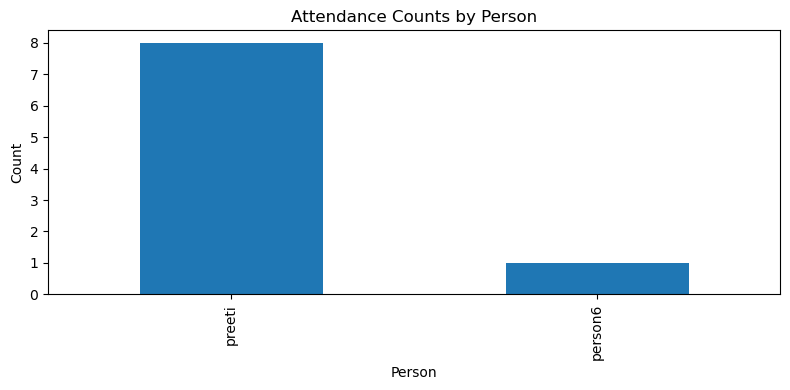

In [24]:
# Cell 10: Attendance viewer and helpers
# - Load and display last N rows
# - Plot simple counts per person (matplotlib)

import pandas as pd
import matplotlib.pyplot as plt

try:
    df_att = pd.read_csv(ATTENDANCE_CSV)
except Exception as e:
    print(f"ERROR reading attendance.csv: {e}")
    df_att = pd.DataFrame(columns=["name","date","time"])

print("Last 10 attendance records:")
print(df_att.tail(10))

if len(df_att) > 0:
    counts = df_att.groupby('name').size().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    counts.plot(kind='bar')
    plt.title('Attendance Counts by Person')
    plt.ylabel('Count')
    plt.xlabel('Person')
    plt.tight_layout()
    plt.show()
else:
    print("No attendance records to plot yet.")


In [25]:
# Cell 11: Create or reset attendance.csv (RUN ONLY IF NEEDED)
# - Safely creates attendance.csv with headers [name,date,time]
# - Use this if the file is missing or you want to clear it

import pandas as pd

try:
    df = pd.DataFrame(columns=["name", "date", "time"])  # empty with headers
    df.to_csv(ATTENDANCE_CSV, index=False)
    print(f"attendance.csv created/reset at: {ATTENDANCE_CSV}")
except Exception as e:
    print("ERROR: Could not create/reset attendance.csv")
    print(f"Details: {e}")



attendance.csv created/reset at: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\attendance.csv


In [26]:
# Cell 12: Create dataset_index.csv from dataset/ (optional)
# - Scans dataset/<person>/*.{jpg,png,jpeg,bmp}
# - Writes CSV with columns: path, person
# - Helpful for auditing or editing the dataset via spreadsheet

import pandas as pd
from pathlib import Path

rows = []
for person_dir in sorted(DATASET_DIR.iterdir()):
    if not person_dir.is_dir():
        continue
    person = person_dir.name
    for p in person_dir.iterdir():
        if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}:
            rows.append({"path": str(p.resolve()), "person": person})

df_index = pd.DataFrame(rows, columns=["path", "person"])
index_path = (PROJECT_DIR / "dataset_index.csv")
df_index.to_csv(index_path, index=False)
print(f"dataset_index.csv created with {len(df_index)} rows at: {index_path}")
print(df_index.head())


dataset_index.csv created with 65 rows at: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\dataset_index.csv
                                                path   person
0  C:\Users\DELL\Desktop\FaceRecognition-main\Fac...  person1
1  C:\Users\DELL\Desktop\FaceRecognition-main\Fac...  person1
2  C:\Users\DELL\Desktop\FaceRecognition-main\Fac...  person1
3  C:\Users\DELL\Desktop\FaceRecognition-main\Fac...  person1
4  C:\Users\DELL\Desktop\FaceRecognition-main\Fac...  person1


In [27]:
# Cell 14: Robust Hyperparameter Tuning (StratifiedKFold with safe n_splits)
# - Avoids CV errors when some classes have few samples
# - Uses the same grids but caps folds by smallest class count

from collections import Counter
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Determine safe number of folds
class_counts = Counter(y_train.tolist())
min_class_count = min(class_counts.values())
safe_folds = max(2, min(5, min_class_count))  # at least 2 folds, at most 5, not exceeding smallest class
print(f"Class counts: {dict(class_counts)} | Using {safe_folds}-fold StratifiedKFold")

skf = StratifiedKFold(n_splits=safe_folds, shuffle=True, random_state=42)

svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1.0],
    'kernel': ['rbf']
}

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

print("Tuning SVM (robust)...")
svm_gs = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=skf,
    n_jobs=-1,
    scoring='accuracy',
    error_score='raise'
)
svm_gs.fit(X_train_pca, y_train)
print("SVM best params:", svm_gs.best_params_)
svm_pred = svm_gs.best_estimator_.predict(X_test_pca)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"SVM tuned test accuracy: {svm_acc:.3f}")

print("\nTuning RandomForest (robust)...")
rf_gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=skf,
    n_jobs=-1,
    scoring='accuracy',
    error_score='raise'
)
rf_gs.fit(X_train_pca, y_train)
print("RF best params:", rf_gs.best_params_)
rf_pred = rf_gs.best_estimator_.predict(X_test_pca)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"RF tuned test accuracy: {rf_acc:.3f}")

# Compare vs previous best
current_best_name = best_name
current_best_acc = results[best_name]['accuracy'] if 'results' in globals() and best_name in results else -1

candidates = [
    ("SVM_TUNED_SAFE", svm_gs.best_estimator_, svm_acc),
    ("RF_TUNED_SAFE", rf_gs.best_estimator_, rf_acc)
]

for cand_name, cand_model, cand_acc in candidates:
    print(f"Candidate {cand_name} accuracy: {cand_acc:.3f}")

# Select improved best
all_options = candidates + [(current_best_name, best_model, current_best_acc)]
new_best_name, new_best_model, new_best_acc = max(all_options, key=lambda t: t[2])

if new_best_acc > current_best_acc:
    print(f"\nNew best model: {new_best_name} with accuracy {new_best_acc:.3f} (prev {current_best_name}: {current_best_acc:.3f})")
    best_name = new_best_name
    best_model = new_best_model
    joblib.dump(best_model, BEST_MODEL_PATH)
    print(f"Updated saved best model at: {BEST_MODEL_PATH}")
else:
    print(f"\nBest model unchanged: {current_best_name} with accuracy {current_best_acc:.3f}")


Class counts: {8: 4, 10: 10, 0: 4, 7: 4, 9: 3, 2: 3, 5: 4, 1: 4, 3: 3, 6: 3, 4: 3} | Using 3-fold StratifiedKFold
Tuning SVM (robust)...
SVM best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM tuned test accuracy: 0.350

Tuning RandomForest (robust)...
RF best params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
RF tuned test accuracy: 0.450
Candidate SVM_TUNED_SAFE accuracy: 0.350
Candidate RF_TUNED_SAFE accuracy: 0.450

Best model unchanged: DecisionTree with accuracy 0.550


In [28]:
# Cell 15: Capture your own images to dataset/<your_name>
# - Enter a folder/person name (e.g., your real name)
# - Captures face crops using Haar cascade and saves 64x64 grayscale images
# - Press 'c' to capture, 'q' to quit

import cv2
from pathlib import Path

person_name = input("Enter person/folder name (e.g., 'alice'): ").strip()
if not person_name:
    raise ValueError("Name cannot be empty.")

save_dir = DATASET_DIR / person_name
save_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving images to: {save_dir}")

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("ERROR: Cannot access webcam.")

count = 0
print("Press 'c' to capture face, 'q' to quit.")

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            print("WARN: Could not read frame.")
            break
        bboxes = detect_faces_gray(frame, scaleFactor=1.2, minNeighbors=5)
        for (x, y, w, h) in bboxes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.imshow('Capture', frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        if key == ord('c'):
            if len(bboxes) == 0:
                print("No face detected. Try again.")
                continue
            # take the first detected face
            (x, y, w, h) = bboxes[0]
            face_img = preprocess_face_crop(frame, (x, y, w, h))
            out_path = save_dir / f"img_{count+1:03d}.png"
            cv2.imwrite(str(out_path), face_img)
            count += 1
            print(f"Saved: {out_path}")
finally:
    cap.release()
    cv2.destroyAllWindows()
    print(f"Capture finished. Total saved: {count}")


Enter person/folder name (e.g., 'alice'):  Prapti


Saving images to: C:\Users\DELL\Desktop\FaceRecognition-main\FaceRecognition-main\dataset\Prapti
Press 'c' to capture face, 'q' to quit.
Capture finished. Total saved: 0
